In [1]:
### import sys
import numpy as np


import ee

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import rasterio as rio
from rasterio.plot import show
import geemap

from sklearn.preprocessing import OneHotEncoder

In [2]:
ee.Initialize()

In [3]:
# Load bbox+fire geometries and push to EE as FeatureCollection
bbox_df = gpd.read_file("../data/unburned/bbox.shp")
fireBounds_df = gpd.read_file("../data/burned/fireBounds.shp")
bounds_df = gpd.read_file("../data/bounds/bounds.shp")

bbox_EE = geemap.gdf_to_ee(bbox_df, geodesic=True)
fireBounds_EE = geemap.gdf_to_ee(fireBounds_df, geodesic=True)

D:\Anaconda\envs\proj\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
D:\Anaconda\envs\proj\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [27]:
taskLst = []
imgLst = []

for fireName, preFireDate, postFireDate, geometry in bounds_df[["FIRE_NAME", "pre-date", "post-date", "geometry"]].values[11:]:

    geometry = ee.Geometry.Rectangle(list(geometry.bounds))

    # Get pre-post fire Landsat 8 images
    preFireImage_l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"
                                    ).filterBounds(geometry
                                    ).filterDate(preFireDate,
                                                 ee.Date(preFireDate).advance(1, "day"))

    postFireImage_l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"
                                     ).filterBounds(geometry
                                     ).filterDate(postFireDate,
                                                  ee.Date(postFireDate).advance(1, "day"))

    preFireImage_l8, postFireImage_l8 = ee.Image(preFireImage_l8.first()), ee.Image(postFireImage_l8.first())

    # Calculate NBR, dNBR, and burn severity
    preFireNBR = preFireImage_l8.normalizedDifference(['SR_B5', 'SR_B7'])
    postFireNBR = postFireImage_l8.normalizedDifference(['SR_B5', 'SR_B7'])
    dNBR = (preFireNBR.subtract(postFireNBR)).multiply(1000).rename("dNBR")

    burnSeverity = dNBR.expression(" (b('dNBR') > 425) ? 4 "    # purple: high severity
                                   ":(b('dNBR') > 225) ? 3 "    # orange: moderate severity
                                   ":(b('dNBR') > 100) ? 2 "    # yellow: low severity
                                   ":(b('dNBR') > -60) ? 1 "    # green: unburned/unchanged
                                   ":0"                         # brown: vegetation growth
                      ).rename("burnSeverity")
    
    # Get SRTM elevation, NLCD land cover, NDVI, and GRIDMET weather
    dem = ee.Image("NASA/NASADEM_HGT/001").select("elevation")
    nlcd2016 = ee.ImageCollection('USGS/NLCD_RELEASES/2016_REL'
                ).select('landcover','impervious','impervious_descriptor','percent_tree_cover'
                ).filter(ee.Filter.eq('system:index', '2016')).first()
    
    ndvi = postFireImage_l8.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")
    
    gridmet = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET"
               ).filterBounds(geometry
               ).filterDate(ee.Date(postFireDate).advance(-3, "day"), postFireDate
               ).select('pr', 'sph', 'th', 'tmmn', 'tmmx', 'vs', 'bi', 'fm100', 'vpd'  
               ).mean()

    # Merge all image bands together
    combined = postFireImage_l8.select('SR_B.'          # post-fire L8 bands 1-7
                              ).addBands(burnSeverity   # classified burn severity
                              ).addBands(dNBR           # dNBR
                              ).addBands(ndvi           # post-fire NDVI
                              ).addBands(dem            # SRTM elevation
                              ).addBands(gridmet        # all GRIDMET bands
                              ).addBands(nlcd2016       # all NLCD bands
                              ).set("FIRE_NAME", fireName)
    imgLst.append(combined)
    
#     task = ee.batch.Export.image.toDrive(image=combined.toUint16(), 
#                                      region = geometry,
#                                      description='first_fire_export',
#                                      folder='fire_folder',
#                                      fileNamePrefix=fireName,
#                                      scale=30,
#                                      crs='EPSG:4326')
#     task.start()

#     taskLst.append(task)
#     taskLst[0].status() #get the upload status of the first task

    # apply reducer and save results


In [28]:
def get_neighbors(band, coords):
    ''' 
    gets features from 8 nearest neighbors
    TL|TM|TR|
    CL|XX|CR|
    BL|BM|BR|
    
    TL: top left
    TM: top middle
    TR: top right
    ML: middle left
    MR: middle right
    BL: bottom left
    BM: bottom middle
    BR: bottom right
    XX: average of all neighbors

    
    Parameters:
    band : ndarray
        The 2-D array with band data
    coords : tuple
        (x,y) tuple with cell coordinates
    
    Returns: list 
        list of neighbor values in the following order [TL, TM, TR, CL, XX, CR, BL, BM, BR]
    '''
    maxx,maxy = band.shape
    x,y = coords
    n_vals = []
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            neighbor = (x+i, y+j)
            is_bounds = (neighbor[0] >= 0) and (neighbor[0] < maxx) and (neighbor[1] >= 0) and (neighbor[1] < maxy)
            if is_bounds:
                n_vals.append(band[neighbor[0], neighbor[1]])
            else:
                n_vals.append(np.nan)
    n_vals[4] = (sum(n_vals[0:4]) + sum(n_vals[5:])) / (len(n_vals)-1) #8 neighbors not including point
    return n_vals

In [29]:
fire_names = bounds_df['FIRE_NAME'][11:].unique()
fire_names

array(['KINCADE', 'KING', 'OAK', 'REDWOOD VALLEY', 'ROCKY', 'WALKER'],
      dtype=object)

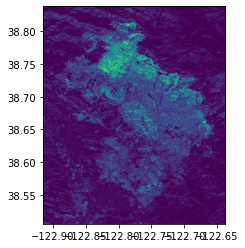

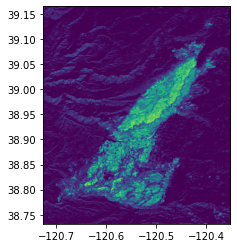

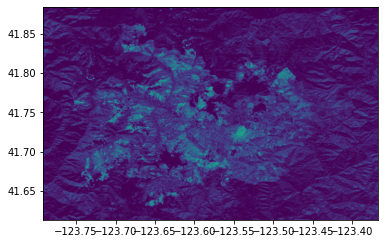

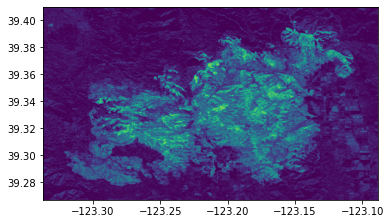

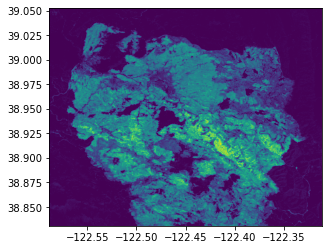

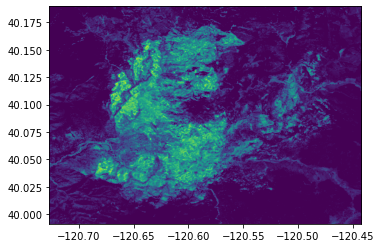

In [30]:
fire_names = bounds_df['FIRE_NAME'][11:].unique()
fire_viz = []
fire_dfs = []

for fire_name in fire_names:
    fire_path = "../data/fire_features/raster/" + fire_name + ".tif"
    fire_io = rio.open(fire_path)
    band_names = fire_io.descriptions
    fire_viz.append(show((fire_io,9)))
    
    y_indx = np.arange(fire_io.height)
    x_indx = np.arange(fire_io.width)

    index = pd.MultiIndex.from_product([x_indx, y_indx])
    
    ###GETING NEIGHBOR FEATURES###

    neighbor_order = ['TL', 'TM', 'TR', 'CL', 'XX', 'CR', 'BL', 'BM', 'BR']
    band_names = fire_io.descriptions
    series_dict = {}
    neighbor_cols = {}

    neighbor_dfs = []

    for i in np.arange(1, len(band_names)+1):
        data = fire_io.read(int(i))
        col_name = band_names[i-1]

        new_names = [n +"_"+ col_name for n in neighbor_order]
        neighbor_cols[col_name] = new_names

        neighbor_arr = []
        for i in x_indx:
            for j in y_indx:
                neighbors = np.array(get_neighbors(data, (i, j)))
                neighbor_arr.append(neighbors)

        neighbor_df = pd.DataFrame(data=neighbor_arr, columns=new_names)
        neighbor_dfs.append(neighbor_df)

        col = pd.Series(data=data.flatten(),index=index)
        series_dict[col_name] = col

    band_df = pd.DataFrame(data=series_dict).reset_index(drop=True)
    all_neighbor_df = pd.concat(neighbor_dfs, axis=1)

    fire_df = pd.concat([band_df, all_neighbor_df], axis=1).dropna()
    
    ###ENCODING LANDCOVER###

    classes = {1: "other",       # open water / perennial ice+snow
               2: "developed",
               3: "other",       # barren land
               4: "forest",
               5: "shrub",
               7: "grassland/herbaceous",
               8: "agriculture",
               9: "other"}       # wetland

    hot_enc = OneHotEncoder()
    encoded_df_array = []

    for col_n in (['landcover'] + neighbor_cols['landcover']):
        if col_n == neighbor_cols['landcover'][4]:
            encoded_df_array.append(pd.DataFrame())
            continue
        unencoded = fire_df[col_n].apply(lambda x: classes[x//10])
        encoded_arr = hot_enc.fit_transform(unencoded.values.reshape(-1, 1)).toarray()
        if col_n == "landcover":
            categories = hot_enc.categories_[0]
        else:
            categories = [col_n[0:2] +"_"+ cat for cat in hot_enc.categories_[0]]
        encoded_df = pd.DataFrame(data=encoded_arr, columns=categories).astype(int)
        encoded_df_array.append(encoded_df)

    all_encoded_df = pd.concat(encoded_df_array, axis=1)

    ###COMBINING AND EXPORTING###
    final_df = fire_df.drop('landcover',axis=1).reset_index(drop=True)
    final_df = pd.concat([final_df, all_encoded_df],axis=1)
    fire_dfs.append(final_df)
    
    fire_io.close()
    end_path = "../data/fire_features/csv/" + fire_name + ".zip"
    final_df.to_csv(end_path)
    
    

In [7]:
test_io = rio.open('../data/fire_features/raster/REDWOOD VALLEY.tif')

In [8]:
band_names = test_io.descriptions

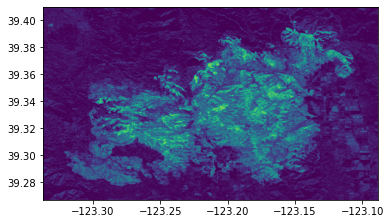

<AxesSubplot:>

In [9]:
show((test_io,9))

In [10]:
y_indx = np.arange(test_io.height)
x_indx = np.arange(test_io.width)

index = pd.MultiIndex.from_product([x_indx, y_indx]) #530 x 920

In [11]:
def get_neighbors(band, coords):
    ''' 
    gets features from 8 nearest neighbors
    TL|TM|TR|
    CL|XX|CR|
    BL|BM|BR|
    
    TL: top left
    TM: top middle
    TR: top right
    ML: middle left
    MR: middle right
    BL: bottom left
    BM: bottom middle
    BR: bottom right
    XX: average of all neighbors

    
    Parameters:
    band : ndarray
        The 2-D array with band data
    coords : tuple
        (x,y) tuple with cell coordinates
    
    Returns: list 
        list of neighbor values in the following order [TL, TM, TR, CL, XX, CR, BL, BM, BR]
    '''
    maxx,maxy = band.shape
    x,y = coords
    n_vals = []
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            neighbor = (x+i, y+j)
            is_bounds = (neighbor[0] >= 0) and (neighbor[0] < maxx) and (neighbor[1] >= 0) and (neighbor[1] < maxy)
            if is_bounds:
                n_vals.append(band[neighbor[0], neighbor[1]])
            else:
                n_vals.append(np.nan)
    n_vals[4] = (sum(n_vals[0:4]) + sum(n_vals[5:])) / (len(n_vals)-1) #8 neighbors not including point
    return n_vals

In [12]:
test_io.descriptions

('SR_B1',
 'SR_B2',
 'SR_B3',
 'SR_B4',
 'SR_B5',
 'SR_B6',
 'SR_B7',
 'burnSeverity',
 'dNBR',
 'NDVI',
 'elevation',
 'pr',
 'rmax',
 'rmin',
 'sph',
 'srad',
 'th',
 'tmmn',
 'tmmx',
 'vs',
 'erc',
 'eto',
 'bi',
 'fm100',
 'fm1000',
 'etr',
 'vpd',
 'landcover',
 'impervious',
 'impervious_descriptor',
 'percent_tree_cover',
 'rangeland_annual_herbaceous',
 'rangeland_bare_ground',
 'rangeland_big_sagebrush',
 'rangeland_herbaceous',
 'rangeland_litter',
 'rangeland_sagebrush',
 'rangeland_sagebrush_height',
 'rangeland_shrub',
 'rangeland_shrub_height')

In [165]:
###GETING NEIGHBOR FEATURES###

neighbor_order = ['TL', 'TM', 'TR', 'CL', 'XX', 'CR', 'BL', 'BM', 'BR']
band_names = test_io.descriptions
series_dict = {}
neighbor_cols = {}

neighbor_dfs = []

for i in np.arange(1, len(band_names)+1):
    data = test_io.read(int(i))
    col_name = band_names[i-1]
    
    new_names = [n +"_"+ col_name for n in neighbor_order]
    neighbor_cols[col_name] = new_names

    neighbor_arr = []
    for i in x_indx:
        for j in y_indx:
            neighbors = np.array(get_neighbors(band, (i, j)))
            neighbor_arr.append(neighbors)

    neighbor_df = pd.DataFrame(data=neighbor_arr, columns=new_names)
    neighbor_dfs.append(neighbor_df)
        
    col = pd.Series(data=data.flatten(),index=index)
    series_dict[col_name] = col
    
band_df = pd.DataFrame(data=series_dict).reset_index(drop=True)
all_neighbor_df = pd.concat(neighbor_dfs, axis=1)

fire_df = pd.concat([band_df, all_neighbor_df], axis=1).dropna()
#values of 101 and 998 are equal to NAN values?
fire_df

,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,burnSeverity,dNBR,NDVI,...,BR_rangeland_shrub,TL_rangeland_shrub_height,TM_rangeland_shrub_height,TR_rangeland_shrub_height,CL_rangeland_shrub_height,XX_rangeland_shrub_height,CR_rangeland_shrub_height,BL_rangeland_shrub_height,BM_rangeland_shrub_height,BR_rangeland_shrub_height
922,7745,8427,9644,10268,13740,15065,12785,1,24,0,...,71.0,21.0,21.0,22.0,21.0,40.000,22.0,71.0,71.0,71.0
923,6997,7875,9129,9528,12289,12557,11315,1,33,0,...,21.0,21.0,22.0,23.0,21.0,33.875,21.0,71.0,71.0,21.0
924,8008,9438,11021,11267,13103,12822,11849,1,22,0,...,52.0,22.0,23.0,23.0,22.0,35.750,52.0,71.0,21.0,52.0
925,8008,9438,11021,11267,13103,12822,11849,1,22,0,...,52.0,23.0,23.0,22.0,21.0,33.250,52.0,21.0,52.0,52.0
926,10326,10986,13526,13411,14456,15001,13933,1,39,0,...,52.0,23.0,22.0,52.0,52.0,44.625,52.0,52.0,52.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488124,8719,9309,10559,11725,14565,18835,14523,1,23,0,...,71.0,52.0,71.0,71.0,71.0,66.250,52.0,71.0,71.0,71.0
488125,8204,8839,9511,10110,13925,15315,12002,1,43,0,...,71.0,71.0,71.0,71.0,71.0,71.000,71.0,71.0,71.0,71.0
488126,8908,9629,11179,12561,18207,20778,15588,1,29,0,...,71.0,71.0,71.0,71.0,52.0,68.625,71.0,71.0,71.0,71.0
488127,9147,9840,11205,12647,16776,19585,15154,1,43,0,...,71.0,71.0,71.0,52.0,71.0,68.625,71.0,71.0,71.0,71.0


In [178]:
neighbor_cols['NDVI'] #helpful dictionary with list of neighbor col names for each feature

['TL_NDVI',
 'TM_NDVI',
 'TR_NDVI',
 'CL_NDVI',
 'XX_NDVI',
 'CR_NDVI',
 'BL_NDVI',
 'BM_NDVI',
 'BR_NDVI']

In [168]:
###ENCODING LANDCOVER###

classes = {1: "other",       # open water / perennial ice+snow
           2: "developed",
           3: "other",       # barren land
           4: "forest",
           5: "shrub",
           7: "grassland/herbaceous",
           8: "agriculture",
           9: "other"}       # wetland
 
hot_enc = OneHotEncoder()
encoded_df_array = []

for col_n in (['landcover'] + neighbor_cols['landcover']):
    if col_n == neighbor_cols['landcover'][4]:
        encoded_df_array.append(pd.DataFrame())
        continue
    unencoded = fire_df[col_n].apply(lambda x: classes[x//10])
    encoded_arr = hot_enc.fit_transform(unencoded.values.reshape(-1, 1)).toarray()
    if col_n == "landcover":
        categories = hot_enc.categories_[0]
    else:
        categories = [col_n[0:2] +"_"+ cat for cat in hot_enc.categories_[0]]
    encoded_df = pd.DataFrame(data=encoded_arr, columns=categories).astype(int)
    encoded_df_array.append(encoded_df)

all_encoded_df = pd.concat(encoded_df_array, axis=1)

all_encoded_df

,agriculture,developed,forest,grassland/herbaceous,other,shrub,TL_agriculture,TL_developed,TL_forest,TL_grassland/herbaceous,...,BM_forest,BM_grassland/herbaceous,BM_other,BM_shrub,BR_agriculture,BR_developed,BR_forest,BR_grassland/herbaceous,BR_other,BR_shrub
0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486146,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
486147,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
486148,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
486149,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [173]:
###COMBINING AND EXPORTING###
final_df = fire_df.drop('landcover',axis=1).reset_index(drop=True)

final_df = pd.concat([final_df, all_encoded_df],axis=1)

Index(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7',
       'burnSeverity', 'dNBR', 'NDVI',
       ...
       'BM_forest', 'BM_grassland/herbaceous', 'BM_other', 'BM_shrub',
       'BR_agriculture', 'BR_developed', 'BR_forest',
       'BR_grassland/herbaceous', 'BR_other', 'BR_shrub'],
      dtype='object', length=453)

In [188]:
fire_name = 'REDWOOD VALLEY'
end_path = "../data/fire_features/csv/" + fire_name + ".zip"

final_df.to_csv(test_path)

In [26]:
test_io.close()